In [1]:
# CNN modelo MobileNetV2, que é leve, eficiente e já vem com pesos pré-treinados no ImageNet.

# Import

In [2]:
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import time
import json
import time
import seaborn as sns
from datetime import datetime

In [3]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, log_loss
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2


In [5]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
#plt.rcParams["image.cmap"] = "gray"

In [6]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

| Parâmetro             | Valor                                                   |
| --------------------- | ------------------------------------------------------- |
| **Tamanho da imagem** | `224x224` (padrão do MobileNetV2)                       |
| **Número de canais**  | 3 (imagens RGB)                                         |
| **Tipo de dado**      | `float32`                                               |
| **Escala de pixel**   | Deve ser normalizada com `preprocess_input` (de -1 a 1) |


In [7]:
# Parâmetros
img_height, img_width = 224, 224
image_size = (img_width, img_height)
batch_size = 32
input_shape = (img_height, img_width, 3)
base_dir = './datasets/Plastic_Classification/'

# Carregar o dataset 

In [8]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # geralmente para teste não embaralha
)

class_names = train_ds.class_names
num_classes = len(class_names)




Found 1441 files belonging to 7 classes.
Using 1153 files for training.
Found 416 files belonging to 7 classes.
Using 83 files for validation.
Found 209 files belonging to 7 classes.


In [9]:
print(train_ds.class_names)

['HDPE', 'LDPA', 'Other', 'PET', 'PP', 'PS', 'PVC']


## Aplicar data_augmentation aprimorado


In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)
], name="data_augmentation")


## Otimização dos datasets com cache, shuffle, prefetch

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Criar o modelo com preprocess_input embutido

In [12]:
# Entrada
input_shape = (224, 224, 3)
inputs = tf.keras.Input(shape=input_shape)

# Pipeline: data_augmentation + normalização
x = data_augmentation(inputs)
x = preprocess_input(x)  # normalização específica do MobileNetV2

# Backbone
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # congelar inicialmente

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(7, activation='softmax')(x)  # 7 classes 'HDPE', 'LDPA', 'Other', 'PET', 'PP', 'PS', 'PVC'

# Modelo final
model = tf.keras.Model(inputs, outputs)


## Compilar o modelo

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## Resumo

In [14]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Treinar o modelo

In [15]:

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Treinamento
start_time = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

end_time = time.time()
training_time = end_time - start_time
print(f"\n Tempo de treinamento: {training_time:.2f} segundos")


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.3197 - loss: 1.9377 - val_accuracy: 0.5783 - val_loss: 1.1062
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.6222 - loss: 1.0199 - val_accuracy: 0.6506 - val_loss: 0.9781
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6758 - loss: 0.8558 - val_accuracy: 0.7349 - val_loss: 0.8073
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7536 - loss: 0.7190 - val_accuracy: 0.7229 - val_loss: 0.7511
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7506 - loss: 0.6949 - val_accuracy: 0.7590 - val_loss: 0.7510
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7785 - loss: 0.6157 - val_accuracy: 0.7349 - val_loss: 0.7310
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8147 - loss: 0.5423 - val_accuracy: 0.7229 - val_loss: 0.7120
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.8231 - loss: 0.5055 - val_accuracy: 0.6867 - val_loss

## Gráfico de acurácia e loss

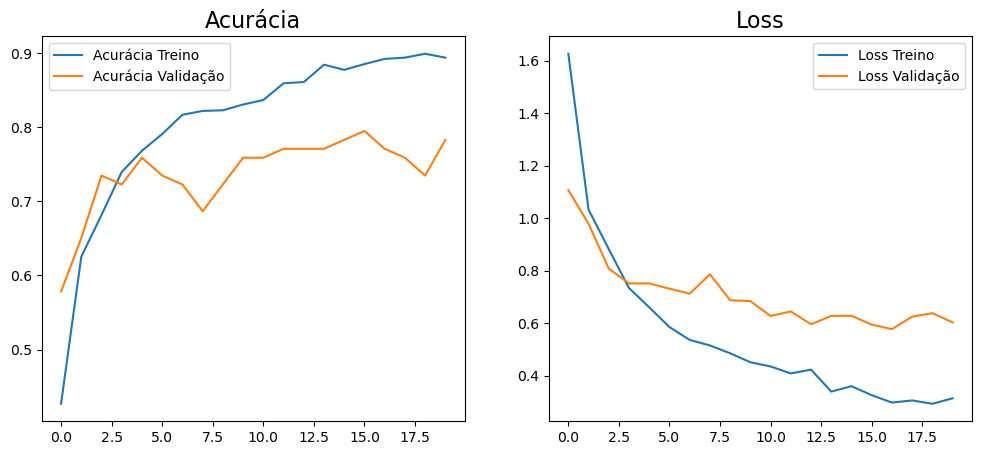

In [16]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia Treino')
plt.plot(epochs_range, val_acc, label='Acurácia Validação')
plt.legend()
plt.title('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss Treino')
plt.plot(epochs_range, val_loss, label='Loss Validação')
plt.legend()
plt.title('Loss')

plt.show()


## Avaliação no conjunto de teste com métricas

In [17]:
start_time = time.time()
loss, accuracy = model.evaluate(test_ds, verbose=1)
end_time = time.time()

print(f"Acurácia: {accuracy:.4f}")
print(f"Loss: {loss:.4f}")
print(f"Tempo de avaliação: {(end_time - start_time):.2f} segundos")


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7701 - loss: 0.6550
Acurácia: 0.7703
Loss: 0.6132
Tempo de avaliação: 10.03 segundos


In [18]:
# Extrair verdadeiros e predições
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)


# Relatório
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step

 Classification Report:

              precision    recall  f1-score   support

        HDPE       0.64      0.77      0.70        30
        LDPA       1.00      0.83      0.91        30
       Other       0.75      0.70      0.72        30
         PET       0.66      0.79      0.72        29
          PP       0.92      0.80      0.86        30
          PS       0.86      0.80      0.83        30
         PVC       0.68      0.70      0.69        30

    accuracy                           0.77       209
   macro avg       0.79      0.77      0.77       209
weighted avg       0.79      0.77      0.77       209



In [19]:
## Matriz de confusão

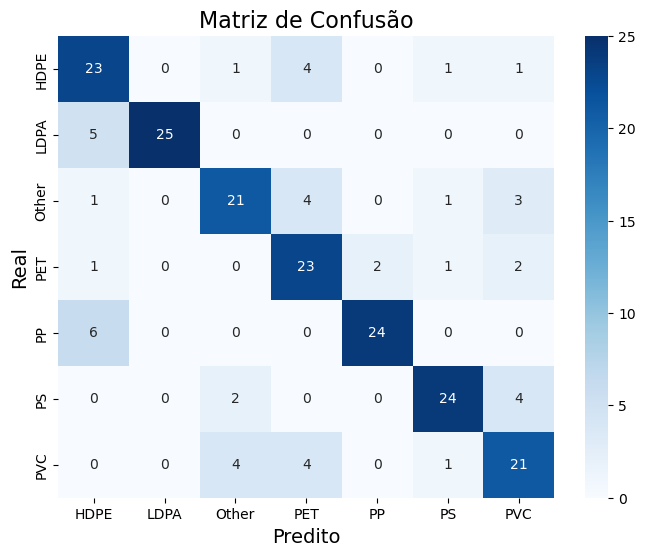

In [20]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


## Curva ROC Multiclasse

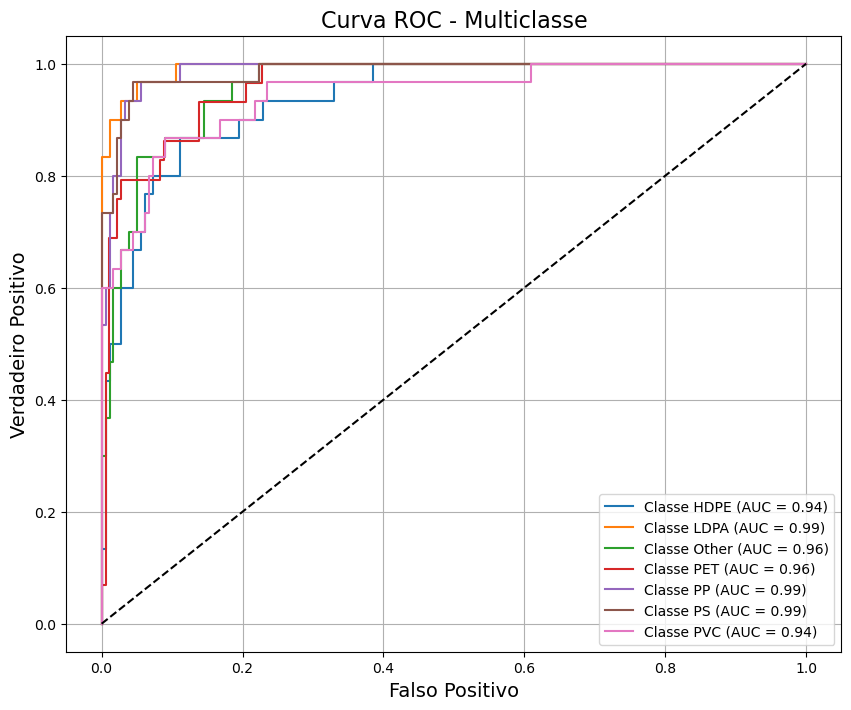

In [21]:
# Binarizar as labels
y_test_bin = label_binarize(y_true, classes=list(range(len(class_names))))
n_classes = y_test_bin.shape[1]

# Curva ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotar ROC multiclasses
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Classe {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC - Multiclasse")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Salvar o modelo e metricas

In [28]:
# Dicionário com as métricas
metrics = {
    "modelo": "MobileNetV2",
    "data": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "num_classes": len(class_names),
    "input_shape": input_shape,
    "accuracy": float(accuracy),
    "loss": float(loss),
    "f1_score_weighted": float(f1_score(y_true, y_pred, average='weighted')),
    "tempo_avaliacao_segundos": round(end_time - start_time, 2),
    "roc_auc_por_classe": {class_names[i]: float(roc_auc[i]) for i in range(n_classes)},
}


In [29]:
# Criar pasta se não existir

model_dir = 'models/09_cnn_mobileNetV2'
os.makedirs(model_dir, exist_ok=True)

# Caminho para salvar
model_path = os.path.join(model_dir, 'plastic_classifier_mobilenetv2_model.keras')

# Salvar modelo no formato Keras
model.save(model_path)

print(f"Modelo salvo em: {model_path}")

Modelo salvo em: models/09_cnn_mobileNetV2\plastic_classifier_mobilenetv2_model.keras


In [31]:
# Caminho para salvar as métricas
metrics_path = os.path.join(model_dir, 'plastic_classifier_mobilenetv2_metrics.json')

# Salvar o dicionário de resultados como JSON
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=4)

print(f"Métricas salvas em: {metrics_path}")

Métricas salvas em: models/09_cnn_mobileNetV2\plastic_classifier_mobilenetv2_metrics.json


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


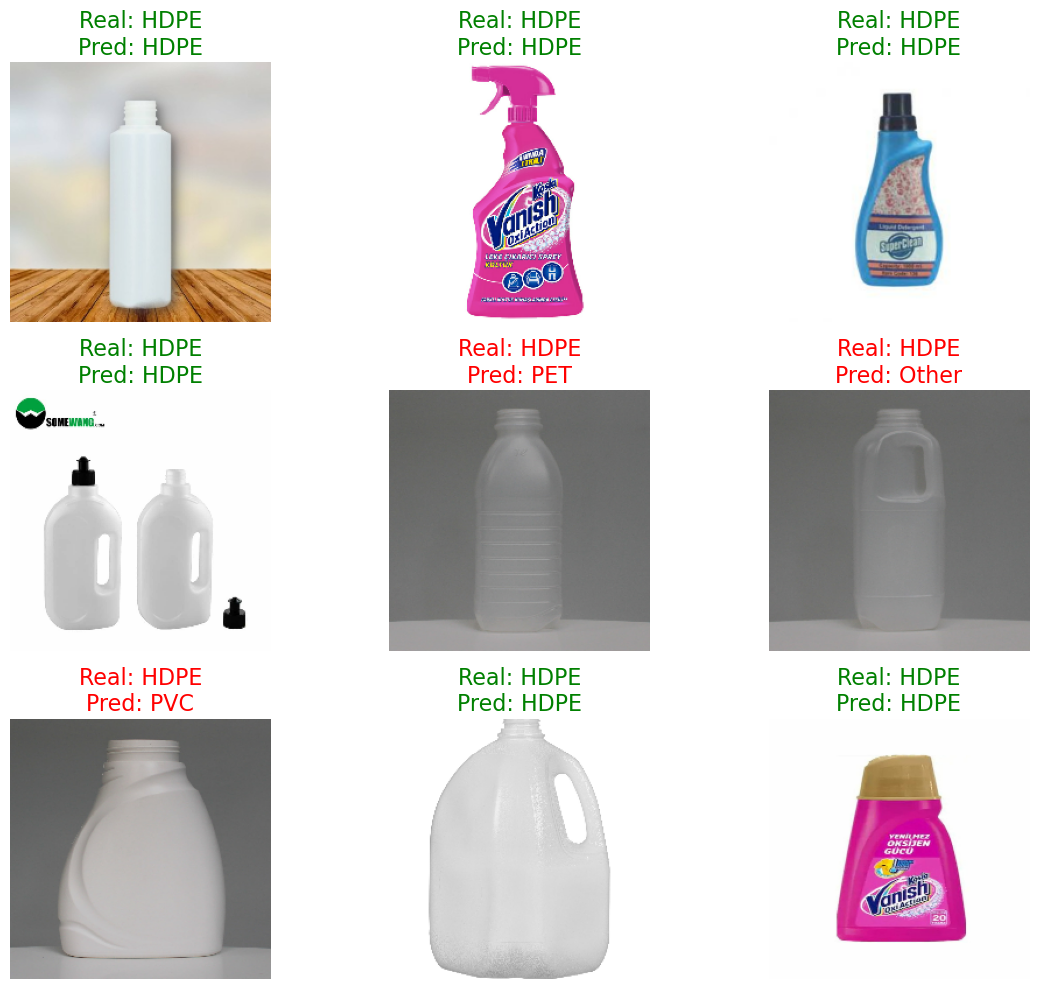

In [32]:


# Obter um batch do conjunto de teste
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = labels.numpy()

# Mostrar as 9 primeiras imagens
plt.figure(figsize=(12, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    
    true_label = class_names[true_classes[i]]
    pred_label = class_names[pred_classes[i]]

    color = "green" if true_label == pred_label else "red"
    plt.title(f"Real: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step  


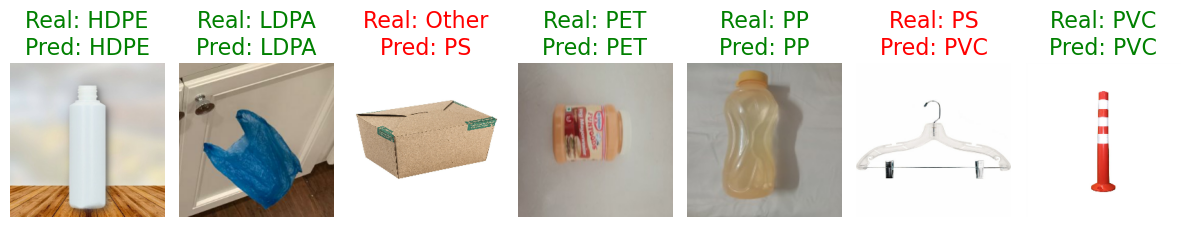

In [27]:
# Pegamos 1 batch grande para buscar amostras de cada classe
for images, labels in test_ds.unbatch().batch(1000).take(1):
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = labels.numpy()

    # Guardar 1 imagem de cada classe verdadeira
    shown_classes = set()
    selected_idx = []

    for i in range(len(true_classes)):
        label = true_classes[i]
        if label not in shown_classes:
            shown_classes.add(label)
            selected_idx.append(i)
        if len(shown_classes) == len(class_names):
            break

# Mostrar uma imagem por classe
plt.figure(figsize=(12, 4))
for i, idx in enumerate(selected_idx):
    ax = plt.subplot(1, len(class_names), i + 1)
    plt.imshow(images[idx].numpy().astype("uint8"))
    
    true_label = class_names[true_classes[idx]]
    pred_label = class_names[pred_classes[idx]]

    color = "green" if true_label == pred_label else "red"
    plt.title(f"Real: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()
